# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

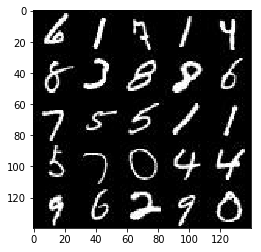

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

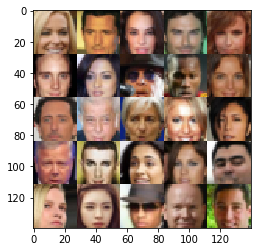

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,shape=(None,
                                                  image_width,
                                                  image_height,
                                                  image_channels),name='input_real')
    input_data_z = tf.placeholder(tf.float32,shape=(None,z_dim),name='input_data_z')
    
    learning_rate = tf.placeholder(tf.float32,shape=None,name='lr')

    return input_real, input_data_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
#使用DCGAN深度卷积对抗生成网络
alpha = 0.2
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        #conv 1
        d_conv1_input = tf.layers.conv2d(images,64,5,strides=2,padding='same')
        d_relu1_output = tf.maximum(alpha * d_conv1_input, d_conv1_input)#tf没有实现relu需要自己实现
        
        #conv2
        d_conv2_input =tf.layers.batch_normalization(tf.layers.conv2d(d_relu1_output,128,5,strides=2,padding='same'))
        d_relu2_output = tf.maximum(alpha * d_conv2_input,d_conv2_input)
        
        #conv3
        d_conv3_input = tf.layers.batch_normalization(tf.layers.conv2d(d_relu2_output,256,5,strides=2,padding='same'))
        d_relu3_out = tf.maximum(alpha * d_conv3_input,d_conv3_input)
        
        logits = tf.layers.dense(tf.reshape(d_relu3_out,(-1,4 * 4 * 256)),1)
        
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
alpha = 0.2
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    #训练的时候禁止重用
    with tf.variable_scope('generator',reuse=False if is_train == True else True):
        #dense layer 1
        fc1 = tf.reshape(tf.layers.dense(z,2 * 2 * 512),(-1 ,2 ,2 ,512))
        fc1 = tf.layers.batch_normalization(fc1,training = is_train)
        fc1_out = tf.maximum(alpha * fc1,fc1)
        
        #conv 2
        g_conv2_input = tf.layers.batch_normalization(tf.layers.conv2d_transpose(fc1_out,256,5,strides=2,padding='valid'),
                                                      training=is_train)
        g_relu2_output = tf.maximum(alpha * g_conv2_input,g_conv2_input)
        
        #conv 3
        g_conv3_input = tf.layers.batch_normalization(tf.layers.conv2d_transpose(g_relu2_output,128,5,strides=2,padding='same'),
                                                      training=is_train)
        g_relu3_output = tf.maximum(alpha * g_conv3_input,g_conv3_input)
        
        #logits 
        logits = tf.layers.conv2d_transpose(g_relu3_output,out_channel_dim,5,strides=2,padding='same')
        
        #output
        return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    #生成模型
    g_model = generator(input_z,out_channel_dim)
    d_model_real,d_logits_real = discriminator(input_real)
    d_model_fake,d_logits_fake = discriminator(g_model,reuse=True)
    
    #损失函数
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))
    #总误差
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #获取所有可训练的变量
    d_vars = [ x for x in tf.trainable_variables() if x.name.startswith('discriminator') ]
    g_vars = [ x for x in tf.trainable_variables() if x.name.startswith('generator') ]
    
    #优化参数
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # 输入
    input_real, input_data_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    #计算损失
    d_loss, g_loss = model_loss(input_real, input_data_z, data_shape[3])
    #优化器
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                input_z_val = np.random.uniform(-1,1,size=(batch_size,z_dim))
                
                sess.run(d_opt, feed_dict = {input_real:batch_images,
                                             input_data_z:input_z_val,
                                             lr:learning_rate
                                            })
                sess.run(g_opt, feed_dict = {input_data_z:input_z_val,
                                             lr:learning_rate
                                            })
                

                
                if steps % 100 == 0:
                    train_loss_d = d_loss.eval({input_data_z:input_z_val,
                                                input_real:batch_images})
                    train_loss_g = g_loss.eval({input_data_z:input_z_val})
                    
                    print("Epoch {}, Dis Loss: {:.4f}, Gen Loss: {:.4f}".format(epoch_i, 
                                                                              train_loss_d, train_loss_g))
                    show_generator_output(sess,25,input_data_z,data_shape[3],data_image_mode)
                    
                
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 0, Dis Loss: 0.7056, Gen Loss: 1.6365


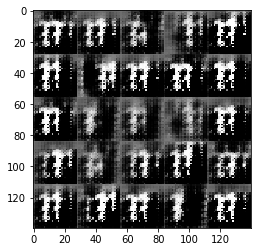

Epoch 0, Dis Loss: 0.6608, Gen Loss: 1.6278


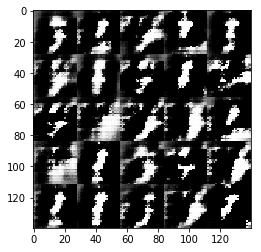

Epoch 0, Dis Loss: 0.7161, Gen Loss: 1.6439


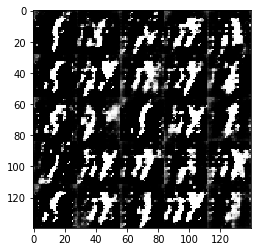

Epoch 0, Dis Loss: 0.4595, Gen Loss: 1.9976


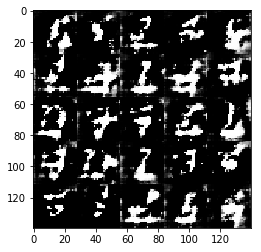

Epoch 0, Dis Loss: 0.6107, Gen Loss: 1.5916


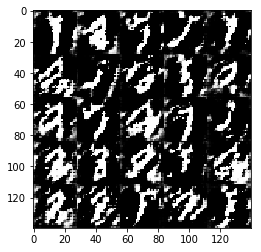

Epoch 0, Dis Loss: 0.8269, Gen Loss: 1.3698


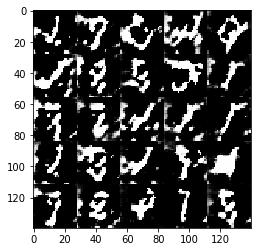

Epoch 0, Dis Loss: 0.7963, Gen Loss: 2.0903


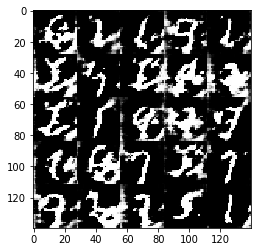

Epoch 0, Dis Loss: 0.8500, Gen Loss: 1.1199


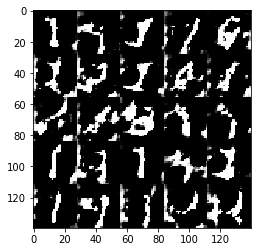

Epoch 0, Dis Loss: 0.7166, Gen Loss: 1.9149


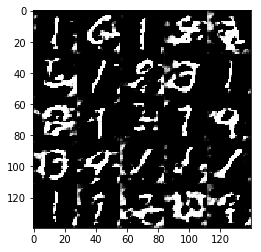

Epoch 1, Dis Loss: 0.6072, Gen Loss: 1.4056


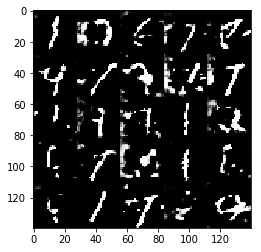

Epoch 1, Dis Loss: 0.8637, Gen Loss: 1.1474


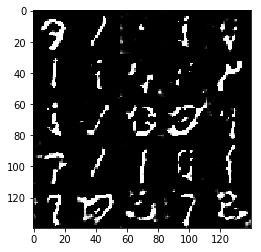

Epoch 1, Dis Loss: 0.9856, Gen Loss: 0.9957


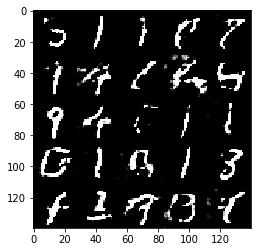

Epoch 1, Dis Loss: 0.8451, Gen Loss: 1.6021


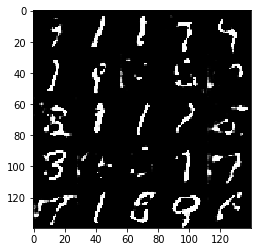

Epoch 1, Dis Loss: 0.9694, Gen Loss: 1.5446


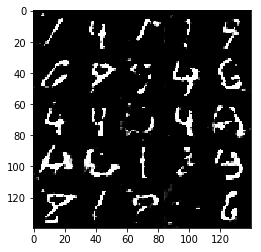

Epoch 1, Dis Loss: 0.8781, Gen Loss: 1.2989


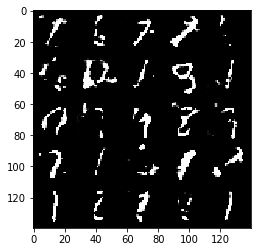

Epoch 1, Dis Loss: 0.8295, Gen Loss: 0.9515


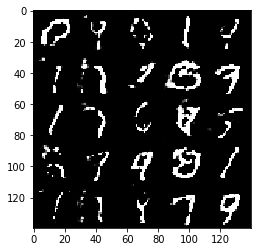

Epoch 1, Dis Loss: 0.9118, Gen Loss: 0.9614


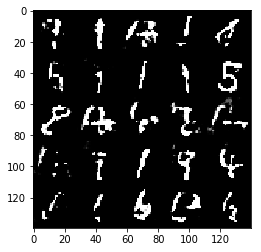

Epoch 1, Dis Loss: 0.8759, Gen Loss: 1.0709


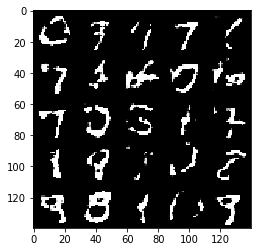

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 0, Dis Loss: 1.0231, Gen Loss: 0.7462


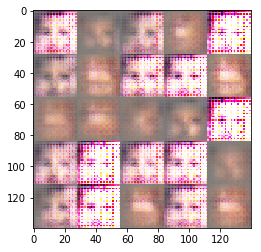

Epoch 0, Dis Loss: 1.0320, Gen Loss: 0.8635


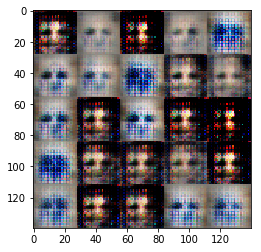

Epoch 0, Dis Loss: 0.7309, Gen Loss: 1.2832


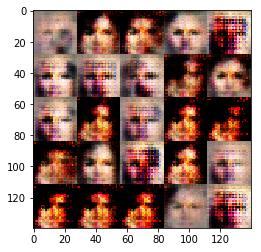

Epoch 0, Dis Loss: 1.1805, Gen Loss: 0.8649


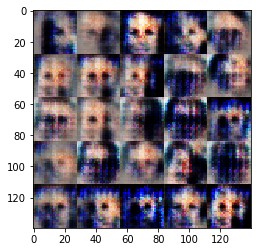

Epoch 0, Dis Loss: 0.9651, Gen Loss: 1.1826


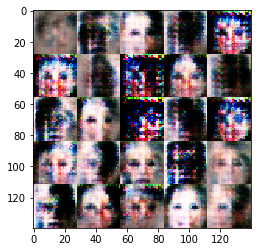

Epoch 0, Dis Loss: 1.0268, Gen Loss: 0.8414


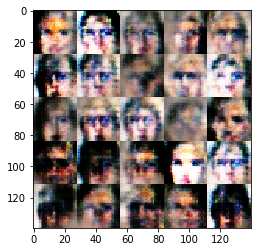

Epoch 0, Dis Loss: 0.9453, Gen Loss: 1.1951


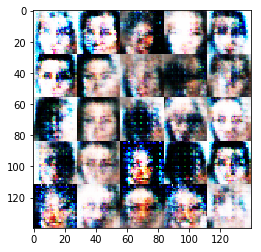

Epoch 0, Dis Loss: 0.7731, Gen Loss: 1.5071


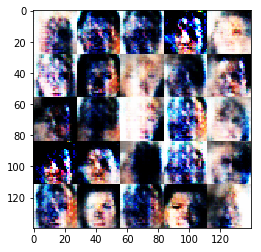

Epoch 0, Dis Loss: 0.9692, Gen Loss: 1.0143


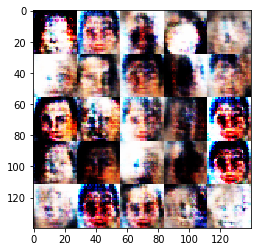

Epoch 0, Dis Loss: 0.9674, Gen Loss: 1.2241


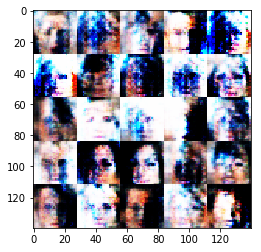

Epoch 0, Dis Loss: 1.1150, Gen Loss: 0.7971


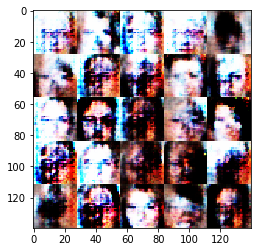

Epoch 0, Dis Loss: 1.0708, Gen Loss: 1.0219


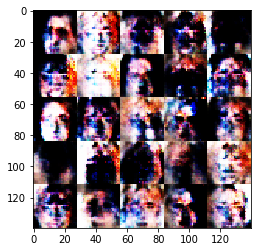

Epoch 0, Dis Loss: 0.8889, Gen Loss: 1.0977


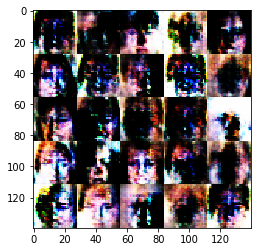

Epoch 0, Dis Loss: 0.8887, Gen Loss: 0.9997


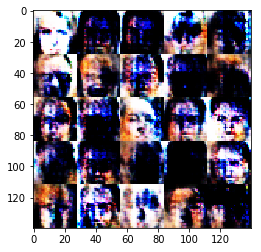

Epoch 0, Dis Loss: 0.7770, Gen Loss: 1.3399


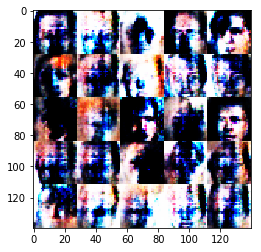

Epoch 0, Dis Loss: 1.0585, Gen Loss: 0.6787


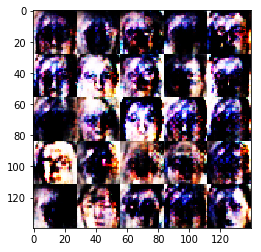

Epoch 0, Dis Loss: 0.9849, Gen Loss: 0.7462


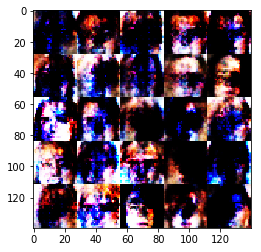

Epoch 0, Dis Loss: 0.9507, Gen Loss: 1.4814


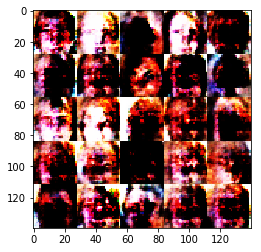

Epoch 0, Dis Loss: 1.1453, Gen Loss: 0.7076


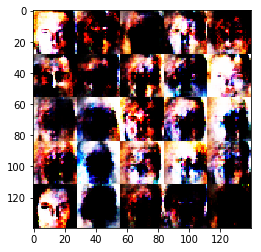

Epoch 0, Dis Loss: 0.9850, Gen Loss: 0.7934


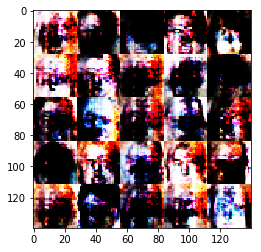

Epoch 0, Dis Loss: 1.2976, Gen Loss: 1.5019


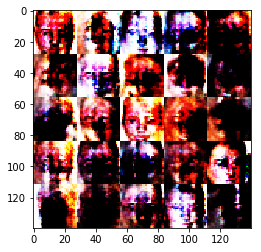

Epoch 0, Dis Loss: 1.0668, Gen Loss: 1.2103


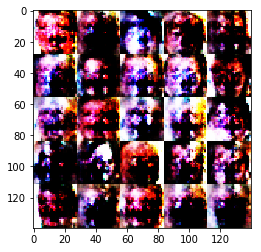

Epoch 0, Dis Loss: 1.2278, Gen Loss: 0.9263


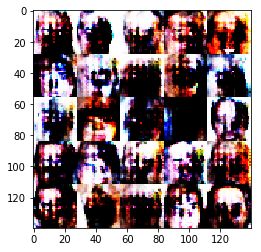

Epoch 0, Dis Loss: 1.1144, Gen Loss: 0.7072


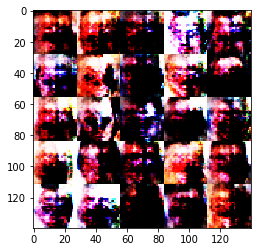

Epoch 0, Dis Loss: 0.9210, Gen Loss: 1.0290


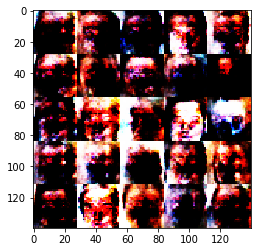

Epoch 0, Dis Loss: 0.9341, Gen Loss: 0.7505


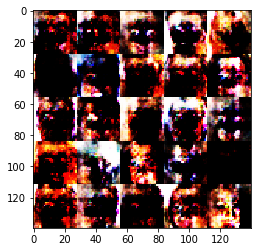

Epoch 0, Dis Loss: 0.9638, Gen Loss: 0.9895


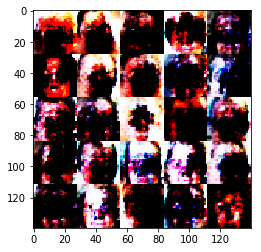

Epoch 0, Dis Loss: 0.9497, Gen Loss: 0.9478


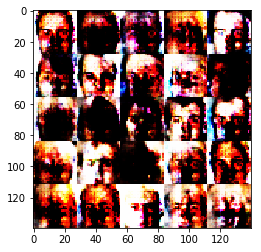

Epoch 0, Dis Loss: 1.1616, Gen Loss: 0.8062


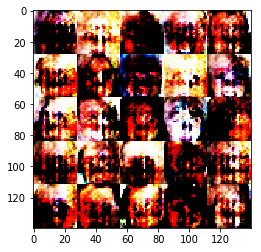

Epoch 0, Dis Loss: 1.0377, Gen Loss: 0.7317


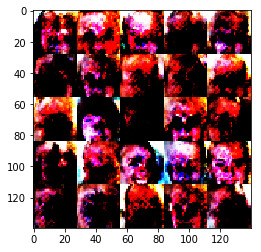

Epoch 0, Dis Loss: 1.1057, Gen Loss: 0.7964


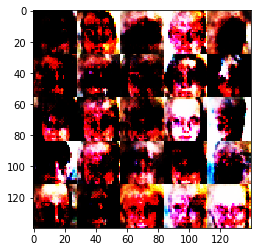

Epoch 0, Dis Loss: 0.9282, Gen Loss: 0.8000


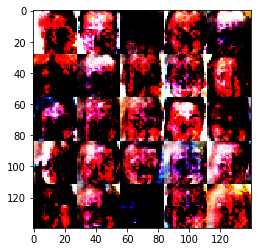

Epoch 0, Dis Loss: 0.9304, Gen Loss: 1.2316


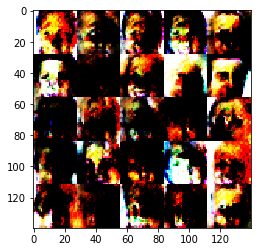

Epoch 0, Dis Loss: 1.1815, Gen Loss: 1.4147


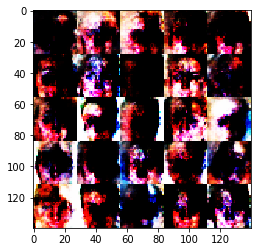

Epoch 0, Dis Loss: 0.8373, Gen Loss: 1.5279


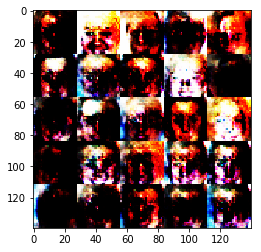

Epoch 0, Dis Loss: 1.0788, Gen Loss: 1.0901


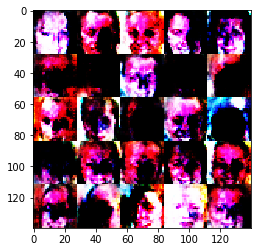

Epoch 0, Dis Loss: 1.1587, Gen Loss: 0.8256


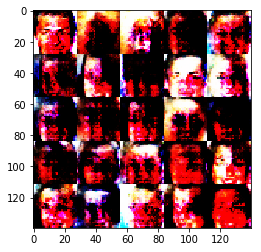

Epoch 0, Dis Loss: 1.0416, Gen Loss: 0.8232


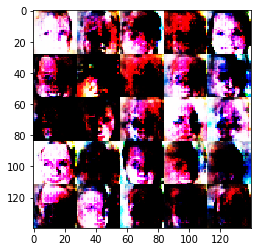

Epoch 0, Dis Loss: 1.2369, Gen Loss: 0.5257


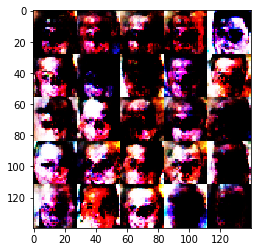

Epoch 0, Dis Loss: 1.0894, Gen Loss: 1.0783


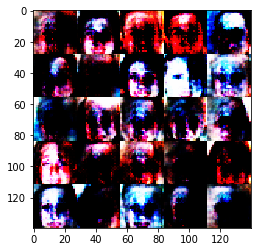

Epoch 0, Dis Loss: 0.8912, Gen Loss: 1.1554


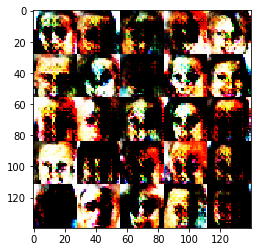

Epoch 0, Dis Loss: 1.0573, Gen Loss: 0.8481


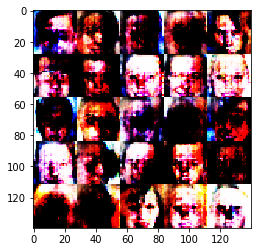

Epoch 0, Dis Loss: 1.1322, Gen Loss: 0.7725


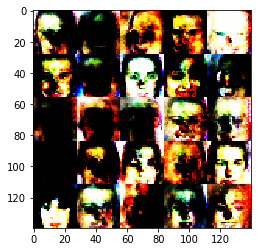

Epoch 0, Dis Loss: 1.1502, Gen Loss: 0.5909


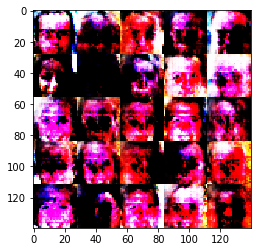

Epoch 0, Dis Loss: 1.1037, Gen Loss: 0.7934


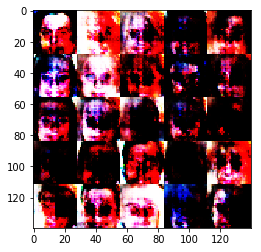

Epoch 0, Dis Loss: 1.0487, Gen Loss: 0.7548


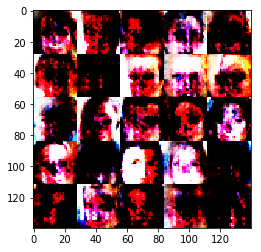

Epoch 0, Dis Loss: 1.1248, Gen Loss: 0.8979


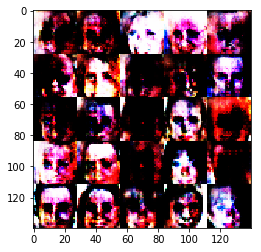

Epoch 0, Dis Loss: 0.9267, Gen Loss: 0.8226


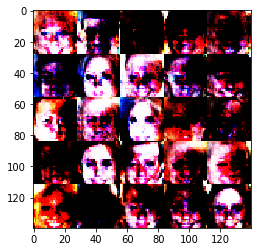

Epoch 0, Dis Loss: 1.1029, Gen Loss: 0.7765


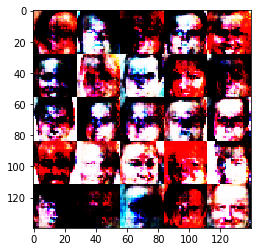

Epoch 0, Dis Loss: 1.0193, Gen Loss: 0.9290


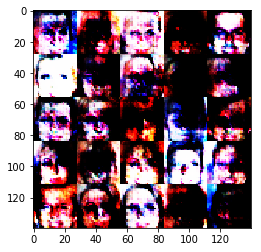

Epoch 0, Dis Loss: 1.1964, Gen Loss: 0.8860


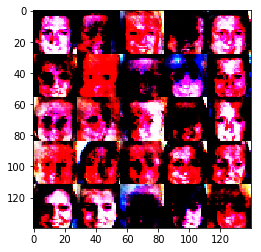

Epoch 0, Dis Loss: 1.2372, Gen Loss: 0.6077


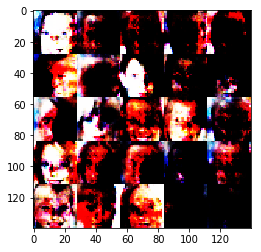

Epoch 0, Dis Loss: 1.0227, Gen Loss: 0.8209


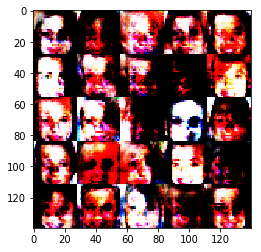

Epoch 0, Dis Loss: 1.1490, Gen Loss: 1.0604


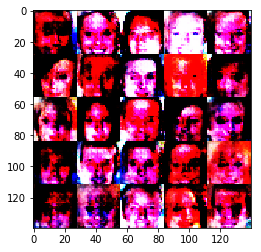

Epoch 0, Dis Loss: 1.1138, Gen Loss: 0.6145


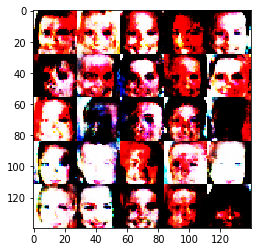

Epoch 0, Dis Loss: 1.1305, Gen Loss: 0.8690


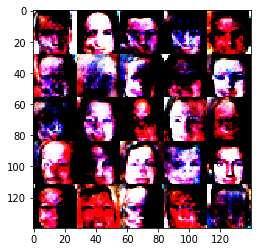

Epoch 0, Dis Loss: 1.1372, Gen Loss: 0.9413


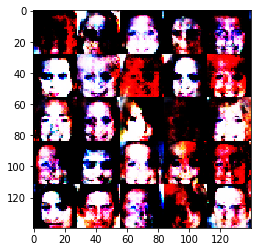

Epoch 0, Dis Loss: 1.2240, Gen Loss: 0.7659


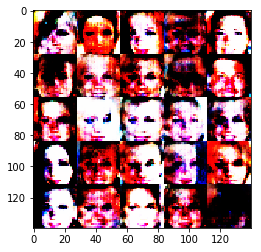

Epoch 0, Dis Loss: 1.0718, Gen Loss: 1.4218


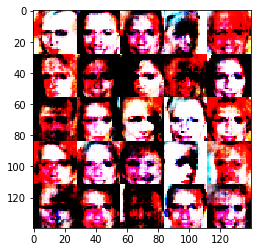

Epoch 0, Dis Loss: 1.2141, Gen Loss: 0.7538


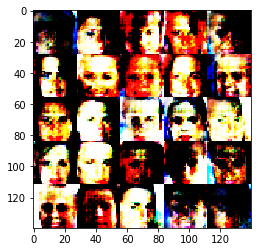

Epoch 0, Dis Loss: 1.0466, Gen Loss: 0.8859


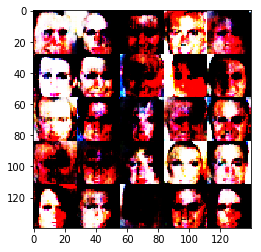

Epoch 0, Dis Loss: 1.3170, Gen Loss: 0.6616


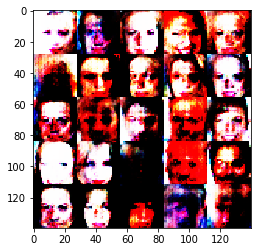

Epoch 0, Dis Loss: 1.0727, Gen Loss: 0.9843


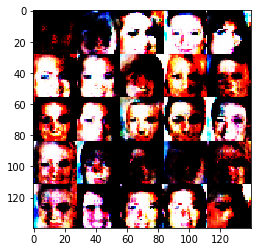

In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。